# <p style="text-align: center;"> Variational Quantum Eigensolver for an Interacting Scalar Field </p>

<p style="text-align: center;"> Ryan LaRose </p>
<p style="text-align: center;"> PHY 855/955 Final Project </p>

<p style="text-align: center;"> <font size=3.5><b>Abstract</b></font> </p>

In this notebook, we compute the ground state energy for a real scalar field with $\lambda \phi^4$ interaction. We use the Variational Quantum Eigensolver (VQE) with a product state ansatz consisting of three parameters. The notebook is designed to run on the "Aspen-4-3Q-A" lattice on [Rigetti Quantum Cloud Services](https://www.rigetti.com/qcs) which consists of three superconducting qubits, or on a quantum computer simulator designed to mimic this chip.

Note that the code must be in a script to run on the actual quantum chip. This notebook is primarily for instructive purposes to explain what is happening in the script, the code of which is identical to this notebook.

## <p style="text-align: center;"> Installing Software </p>

If you don't have the necessary software installed (or are running on Binder), run the cells below. This will automatically install all the other requirements for the notebook.

In [ ]:
"""Install software, if necessary. (Uncomment these lines if needed, then run the cell.)"""
#!pip install pyquil==2.4.0
#!pip install matplotlib
#!pip install scipy

## <p style="text-align: center;"> Imports </p>

We first import the necessary packages. The software pyQuil is developed by Rigetti, a start-up quantum computing company founded by Chad Rigetti in California. Other companies have quantum computers (e.g. IBM and Google) as well as their own software to use them [1]. IBM's computers are based on a queue system, which makes is difficult to run variational quantum algorithms. Google's quantum computers are not currently open to the public. For these reasons, we use Rigetti.

In [1]:
"""Imports."""
from math import pi
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from pyquil import Program, get_qc
from pyquil.gates import H, S, RX, MEASURE

## <p style="text-align: center;"> Constants and Parameters </p>

The code cell below defines two important quantities for this notebook. First, the parameter `omega` dictates the interaction strength of the field (see Hamiltonian below). Second, the `computer` is which computer we will use to execute the algorithm. Quantum computer simulators are classical programs designed to mimic the (noiseless) evolution of a quantum computer. It is possible to artificially inject a noise model into a quantum computer simulator, which can be useful in a variety of situations.

In [2]:
"""Parmeters/constants."""
# Value of \omega_\phi [1] which determines the interaction strength
# omega = 1 <==> no interaction, omega --> 0 <==> large interaction
omega = 0.5

# Computer to run on
simulator = "3q-qvm"
qcomputer = "Aspen-4-3Q-A"
computer = get_qc(qcomputer, as_qvm=True) # Change to as_qvm=False to run on QC. Must have reservation.

## <p style="text-align: center;"> Scalar Quantum Field theory </p>

We consider the scalar quantum field with $\lambda \phi^4$ interaction term, the Lagrangian of which can be written

\begin{equation}
    \mathcal{L} = \frac{1}{2} \partial_\mu \phi \partial^\mu \phi - \frac{1}{2} m_0^2 \phi^2 - \frac{\lambda_0^2}{4!} \phi^4 .
\end{equation}

Here, $m_0$ is the bare mass of the field. The physical mass gets affected by the interaction term $\lambda_0 \phi^4$. It is possible to renormalize the theory by computing the physical mass via $m = E_1 - E_0$ [2]. In this code, we only consider computing the ground state energy $E_0$. The first excited state energy could be computed by similar methods, for example those of [3].

The steps to obtaining a qubit Hamiltonian from such a Lagrangian are described in detail in my write-up and slides. Below, we will use the form of the Hamiltonian derived in [4] for three qubits. 


We do mention one effect due to discretization. Namely, our lattice simulation is valid only at low energies (momenta), as can be seen by the following plot. This plot shows the continuous dispersion related and the discrete dispresion relation. The region where they overlap (at low momenta) is the valid region for our simulation. Note that coefficients in this plot were chosen arbitrarily for visual appearance. The effective shape of both curve and physics is contained in this plot, however.

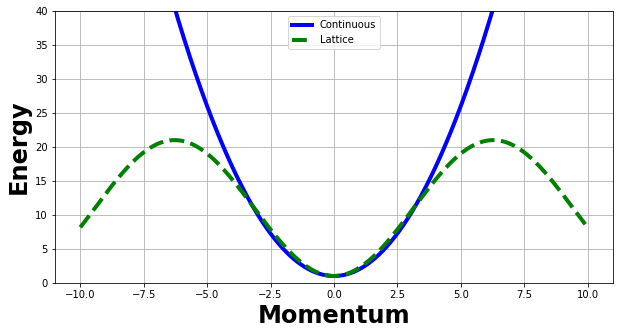

In [3]:
"""Plotting the continuous and lattice dispersion relations. 
See writeup/slides for derivations of these.
"""
ks = np.linspace(-10.0, 10.0, 1000)
m = 1.0
cs = m**2 + ks**2
ds = m**2 + 20 * np.sin(ks / 4)**2

plt.figure(figsize=(10, 5))
plt.plot(ks, cs, color="b", linewidth=4, label="Continuous")
plt.plot(ks, ds, "--", color="green", linewidth=4, label="Lattice")
plt.grid()
plt.legend(loc="upper center")
plt.ylim((0, 40))
plt.xlabel("Momentum", fontsize=24, fontweight="bold");
plt.ylabel("Energy", fontsize=24, fontweight="bold");

We now discuss our choice of variational ansatz for the VQE algorithm.

## <p style="text-align: center;"> Variational Ansatz </p>

The variational ansatz is key to the success of VQE. Here we consider a simple tensor product ansatz that consists of Pauli-$X$ rotations about each qubit by independent angles. A more sophisticated ansatz, for example one with entanglement, may be required to reach the true ground state energy.

In [4]:
"""Define the ansatz circuit."""
def ansatz():
    """Returns a circuit with a product state ansatz."""
    # Get a circuit and classical memory register
    circ = Program()
    creg = circ.declare("ro", memory_type="BIT", memory_size=3)

    # Define parameters for the ansatz
    angles = circ.declare("theta", memory_type="REAL", memory_size=3)

    # Add the ansatz
    circ += [RX(angles[0], 10), RX(angles[1], 11), RX(angles[2], 17)]
    
    return circ, creg

Note that the odd qubit indexing (10, 11, 17) is for the quantum computer we'll use. One has to explicity use the right qubit indices unless Rigetti QCS with throw an error instead of, say, translating to the usable qubit indices...

In the code below, we call our ansatz function and print out the circuit.

In [5]:
"""Get an example of ansatz."""
circ, creg = ansatz()

print(circ)

DECLARE ro BIT[3]
DECLARE theta REAL[3]
RX(theta[0]) 10
RX(theta[1]) 11
RX(theta[2]) 17



This notation for representing quantum circuits is known as Quil, the Quantum Instruction Language, which was developed by Rigetti. Other "quantum assembly languages" exist such as OpenQASM by IBM and Blackbird by Xanadu.

## <p style="text-align: center;"> Qubit Hamiltonian </p>

We use the form of the qubit Hamiltonian presented in [4] which is written

\begin{equation}
    H = H_{\text{basis}} + \delta H
\end{equation}

where 

\begin{equation}
    H_{\text{basis}} = \omega_\phi [4 I - 2 Z_0 - Z_1 - \frac{1}{2} Z_2 ]
\end{equation}

and

\begin{equation}
    \delta H = \frac{1 - \omega_\phi^2}{\omega_\phi} [ a Z_0 X_1 Z_2 
    + b X_0 X_1 
    + a Y_0 Y_1 Z_2
    + b Y_0 Y_1 
    + c Z_0 X_1 Z_2
    + d Z_0 X_1
    + e X_1 Z_2 
    + f X_1 
    - Z_0
    - \frac{1}{2} Z_1
    - \frac{1}{4} Z_2
    + 2 I
    ]
\end{equation}

and coefficents are given by

\begin{align}
    a &= \frac{ \sqrt{3} - \sqrt{5} }{8} \\
    b &= \frac{ \sqrt{3} + \sqrt{5} }{8} \\
    c &= \frac{1 - \sqrt{3} + \sqrt{21} - \sqrt{15}}{8 \sqrt{2}} \\
    d &= \frac{1 + \sqrt{3} - \sqrt{21} - \sqrt{15}}{8 \sqrt{2}} \\
    e &= \frac{1 - \sqrt{3} - \sqrt{21} + \sqrt{15}}{8 \sqrt{2}} \\
    f &= \frac{1 + \sqrt{3} + \sqrt{21} + \sqrt{15}}{8 \sqrt{2}} 
\end{align}

Here, $\omega_\phi$ is considered a tuning parameter for "how much $\delta H$ to include." It is related to the coefficient strength $\lambda$ of the field theory.

The cell below defines these coefficients in code. Here, we store coefficients in a Python dictionary for easy access in the VQE algorithm. The format of the dictionary is "term of Hamiltonian" --> "value of coefficient." We number the terms of the Hamiltonian starting with zero in the $H_{\text{basis}}$ term, ignoring the trivial identity terms, then going through to the $\delta H$ term, again ignoring identity terms.

In [6]:
"""Defining coefficents of Hamiltonian in a dictionary. 

key = which term of Hamiltonian, value = coefficient.
"""

# "Global" coefficients on H_basis and \delta H
Cbasis = omega
Cdelta = (1.0 - omega**2) / omega

# Numerical values of coefficeints above
a = (np.sqrt(3.0) - np.sqrt(5.0)) / 8.0
b = (np.sqrt(3.0) + np.sqrt(5.0)) / 8.0
c = (1.0 - np.sqrt(3.0) + np.sqrt(21.0) - np.sqrt(15.0)) / 8 / np.sqrt(2.0)
d = (1.0 + np.sqrt(3.0) - np.sqrt(21.0) - np.sqrt(15.0)) / 8 / np.sqrt(2.0)
e = (1.0 - np.sqrt(3.0) - np.sqrt(21.0) + np.sqrt(15.0)) / 8 / np.sqrt(2.0)
f = (1.0 + np.sqrt(3.0) + np.sqrt(21.0) + np.sqrt(15.0)) / 8 / np.sqrt(2.0)

# Dictionary of coefficients, starting numbering with H_basis and then \delta H
coeffs = {0: -2.0 * Cbasis,
          1: -1.0 * Cbasis,
          2: -0.5 * Cbasis,
          3: a * Cdelta,
          4: b * Cdelta,
          5: a * Cdelta,
          6: b * Cdelta,
          7: c * Cdelta,
          8: d * Cdelta,
          9: e * Cdelta,
         10: f * Cdelta,
         11: -1.0 * Cdelta,
         12: -0.5 * Cdelta,
         13: -0.25 * Cdelta}

We now define the basis measurements for each term in the Hamiltonian, using the same indexing scheme as above. These measurements are explained in detail in my project write-up and slides. Essentially, we rotate to the eigenbasis of the particular Pauli operator we want to compute an expectation of. Measuring in the computational basis then allows us to approximate the expectation value by classical post-processing.

In [7]:
"""Defining rotation operators in a dictionary. 

key = which term of Hamiltonian, value = which basis to measure in.
"""
# Helper function
def meas(pauli, qubit):
    """Returns a pyquil.Program with the correct basis measurement 
    for the given Pauli operator and qubit.
    
    Args:
        pauli : str
            Either "X", "Y", or "Z".

        qubit : int
            Index of qubit in the Hamiltonian.
            Note: This should be an actual physical qubit index
                  on the qubit lattice being considered if running
                  on a quantum chip.
    """
    # Get the index of the classical register for the given qubit index
    if qubit == 10:
        ind = 0
    elif qubit == 11:
        ind = 1
    elif qubit == 17:
        ind = 2
    else:
        raise ValueError("Unsupported qubit index for computer. Rigetti will let you know about this...")

    # Do the appropriate basis measurement
    if pauli == "Z":
        return Program(MEASURE(qubit, creg[ind]))
    elif pauli == "X":
        return Program(H(qubit), MEASURE(qubit, creg[ind]))
    elif pauli == "Y":
        return Program(S(qubit), H(qubit), MEASURE(qubit, creg[ind]))
    else:
        raise ValueError("Unsupported operator. Enter X, Y, or Z.")


# Dictionary
measure = {0: meas("Z", 10),
           1: meas("Z", 11),
           2: meas("Z", 17),
           3: meas("Z", 10) + meas("X", 11) + meas("Z", 17),
           4: meas("X", 10) + meas("X", 11),
           5: meas("Y", 10) + meas("Y", 11) + meas("Z", 17),
           6: meas("Y", 10) + meas("Y", 11),
           7: meas("Z", 10) + meas("X", 11) + meas("Z", 17),
           8: meas("Z", 10) + meas("X", 11),
           9: meas("X", 11) + meas("Z", 17),
          10: meas("X", 11),
          11: meas("Z", 10),
          12: meas("Z", 11),
          13: meas("Z", 17)}

## <p style="text-align: center;"> Computing an Expectation Value </p>

We can now do the VQE algorithm. We first write a helper function which computes the expectation value of one term in the Hamiltonian, for a given set of angles, on a given computer. The number of `shots` is the number of times to sample from the circuit in order to estimate probabilities. The `verbose` option is a flag for printing out the circuit that is being executed, which is helpful for debugging.

In [8]:
def expectation(term, angles, computer, shots=10000, verbose=False):
    """Returns the expectation value <angles|H_{term}|angles>."""   
    circ, creg = ansatz()
    
    circ += measure[term]
    
    # Set the number of shots
    circ.wrap_in_numshots_loop(shots)
    
    # Verbose option
    if verbose:
        print("Circuit:\n=======")
        print(circ)
    
    # Execute the circuit
    executable = computer.compile(circ)
    res = computer.run(executable, memory_map={"theta": angles})
    
    # Do the postprocessing
    tot = 0.0
    for vals in res:
        tot += (-1)**sum(vals)
    return tot / shots

We use the above function to compute the expectation for a given term in the Hamiltonian and an arbitrary set of angles in the ansatz. One can vary these to see how the expectation value changes.

In [9]:
"""Example of computing an expectation."""
term = 0
angles = [0, pi, 0]

expectation(term, angles, computer, verbose=True)

Circuit:
DECLARE ro BIT[3]
DECLARE theta REAL[3]
RX(theta[0]) 10
RX(theta[1]) 11
RX(theta[2]) 17
MEASURE 10 ro[0]



1.0

## <p style="text-align: center;"> Computing a Weighted Expecation Value </p>

The above function didn't take into account the coefficient of the term in the Hamiltonian. We write a function below that takes care of this for us.

In [10]:
def weighted_expectation(term, angles, computer, shots=10000, verbose=False):
    """Returns coeff * <angles|H_{term}|angles>."""
    return coeffs[term] * expectation(term, angles, computer, shots, verbose)

As above, we compute an exampled "weighted expectation" for the above `term` and set of `angles`.

In [11]:
"""Example of computing a weighted expectation."""
weighted_expectation(term, angles, computer, verbose=False)

-1.0

## <p style="text-align: center;"> Computing the Total Energy </p>

With the above helper function, it is now easy to loop over all terms in the Hamiltonian and add up the weighted expectation values to get the total energy for a given set of angles. The below function does this operation. Note that we add the coefficients of the identity operators outside of this loop. (We don't need a quantum algorithm for this! It's just a constant offset.)

In [12]:
"""Define a function to compute the energy for a set of angles."""
def energy(angles, computer, shots=10000, verbose=False):
    """Returns the energy <angles|H|angles>."""
    # Variable to store the total energy
    tot = 0.0
    
    # Loop over all terms and add the weighted expectations
    for term in coeffs.keys():
        tot += weighted_expectation(term, angles, computer, shots, verbose)
    
    # Add in the constant values from the Hamiltonian
    tot += 4 * Cbasis
    tot += 2 * Cdelta
    
    return tot

And again we'll compute the energy for an example set of angles, this time a randomly generated set of three angles.

In [13]:
"""Compute the energy for a random set of angles."""
energy(np.random.rand(3), computer)

1.0604309266122893

Now that we have a function for computing the energy, we just need to vary the parameters to find the minimum. There are many methods for this. The simplest, and most computationally expensive, is a grid search over the angles. Below we use a minimization algorithm known as Constrained Optimization BY Linear Approximation (COBYLA) which is implemented in Scipy Optimize.

# <p style="text-align: center;"> Minimizing the Total Energy </p>

In [14]:
"""Define a list to store the objective function value at each iteration (for plotting)."""
OBJVALS = []

In [15]:
"""Define the objective function."""
def obj(angles):
    """Returns the energy for a given set of angles."""
    val = energy(angles, computer, shots=10000, verbose=False)
    OBJVALS.append(val)
    print("Current energy =", round(val, 7), end="\r")
    return val

In [16]:
"""Do the minimization."""
start = time.time()
res = minimize(obj, np.random.rand(3), method="COBYLA")
end = time.time()
print("Total runtime = {} minutes.".format((end - start) / 60))

Total runtime = 5.8602989435195925 minutes.


In [17]:
"""Print out the final result."""
print(res)

     fun: 0.6685095783672974
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 43
  status: 1
 success: True
       x: array([-0.17313439, -0.03250566,  0.22492333])


## <p style="text-align: center;"> Plotting the Energy vs Iteration Curve </p>

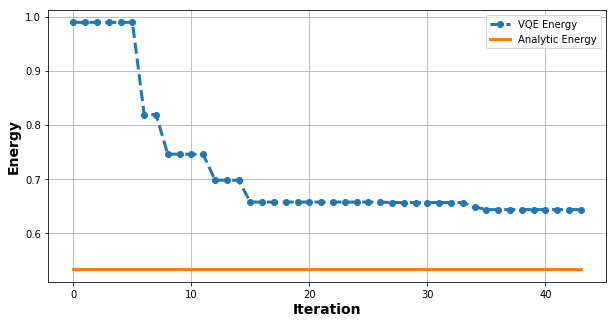

In [18]:
"""Plot the energy vs iteration"""
# Only include the decreasing costs, since the optimizer tries random values occasionally
energies = [OBJVALS[0]]
for x in OBJVALS:
    if x < energies[-1]:
        energies.append(x)
    else:
        energies.append(energies[-1])

# Do the plotting
plt.figure(figsize=(10, 5))
plt.plot(energies, "--o", linewidth=3, label="VQE Energy")
plt.xlabel("Iteration", fontsize=14, fontweight="bold")
plt.ylabel("Energy", fontsize=14, fontweight="bold")

# Put a line at the actual ground state energy (see below)
GSENERGY = 0.53232723
plt.plot(GSENERGY * np.ones_like(energies), linewidth=3, label="Analytic Energy")

plt.grid()
plt.legend()

## <p style="text-align: center;"> Checking the Result </p>

This is just an eight by eight matrix -- we can diagonalize this with classical methods. We just need to have a matrix representation of the Hamiltonian, which we obtain below.

In [19]:
"""Classically diagonalize the Hamiltonian."""
# Define the Pauli matrices
I = np.identity(2, dtype=np.complex64)
X = np.array([[0, 1], [1, 0]], dtype=np.complex64)
Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex64)
Z = np.array([[1, 0], [0, -1]], dtype=np.complex64)

# Helper function for doing three tensor products
def kron(a, b, c):
    return np.kron(a, np.kron(b, c))

# Initialize the Hamiltonian
H = np.zeros((8, 8), dtype=np.complex64)

# Add in each term of the Hamiltonian from above
# H_basis terms
H += 4 * Cbasis * kron(I, I, I)
H += coeffs[0] * kron(Z, I, I)
H += coeffs[1] * kron(I, Z, I)
H += coeffs[2] * kron(I, I, Z)

# \delta H terms
H += coeffs[3] * kron(Z, X, Z)
H += coeffs[4] * kron(X, X, I)
H += coeffs[5] * kron(Y, Y, Z)
H += coeffs[6] * kron(Y, Y, I)
H += coeffs[7] * kron(Z, X, Z)
H += coeffs[8] * kron(Z, X, I)
H += coeffs[9] * kron(I, X, Z)
H += coeffs[10] * kron(I, X, I)
H += coeffs[11] * kron(Z, I, I)
H += coeffs[12] * kron(I, Z, I)
H += coeffs[13] * kron(I, I, Z)
H += 2 * Cdelta * kron(I, I, I)

# Print out the matrix of the Hamiltonian
print(H)

[[ 0.625     +0.j  0.        +0.j  0.43582678+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.09450322+0.j  0.        +0.j]
 [ 0.        +0.j  1.875     +0.j  0.        +0.j  1.0130619 +0.j
   0.        +0.j  0.        +0.j  0.        +0.j -0.09450322+0.j]
 [ 0.43582678+0.j  0.        +0.j  3.125     +0.j  0.        +0.j
   1.3935413 +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.0130619 +0.j  0.        +0.j  4.375     +0.j
   0.        +0.j  1.5825477 +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  1.3935413 +0.j  0.        +0.j
   5.625     +0.j  0.        +0.j  2.1484628 +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.5825477 +0.j
   0.        +0.j  6.875     +0.j  0.        +0.j  2.3357744 +0.j]
 [ 0.09450322+0.j  0.        +0.j  0.        +0.j  0.        +0.j
   2.1484628 +0.j  0.        +0.j  8.125     +0.j  0.        +0.j]
 [ 0.        +0.j -0.09450322+0.j  0.        +0.j  0.        +0.j
   

Now we can diagonalize it to see the "analytic" ground state energy, as well as the ground state wavefunction.

In [20]:
"""Classically diagonalize the Hamiltonian."""
# Get the eigenvalues and eigenvectors
evals, evecs = np.linalg.eigh(H)

# Grab the ground state energy and wavefunction (evals/evecs are sorted)
gs_energy = evals[0]
gs_wavefunction = evecs[0]

# Display them
print("Ground state energy:", gs_energy)
print("Ground state wavefunction:", *gs_wavefunction, sep="\n")

Ground state energy: 0.53232723
Ground state wavefunction:
(0.9767324+0j)
(2.7024597e-16+0j)
(-0.21043499+0j)
(-2.173432e-17+0j)
(0.038632505+0j)
(7.724141e-18+0j)
(0.014783568+0j)
(-2.3814741e-20+0j)


The analytic ground state energy was included on the above plot. We can now also compare the ground state wavefunction found from the ansatz, which we do below.

In [21]:
"""Print out the ground state wavefunction found by the optimal angles in the ansatz."""
# Rx gate as a matrix
rxmat = lambda theta: np.cos(theta / 2) * I - 1j * np.sin(theta / 2) * X

opt = res["x"]

rx0 = rxmat(opt[0])
rx1 = rxmat(opt[1])
rx2 = rxmat(opt[2])

mat = kron(rx0, rx1, rx2)

vqe_wavefunction = mat[:, 0]

print("Ground state wavefunction computed:", *vqe_wavefunction, sep="\n")

Ground state wavefunction computed:
(0.98983115+0j)
-0.11178974j
0.016088976j
(0.0018170598+0j)
0.085901596j
(0.0097015705+0j)
(-0.001396267+0j)
0.00015769187j


Comparing amplitudes is extremely fun, but we can also compute the overlap of the analytic and VQE ground state wavefunctions:

In [22]:
"""Compute the overlap of the analytic and VQE ground state wavefunctions."""
overlap = abs(np.dot(gs_wavefunction.conj().T, vqe_wavefunction))**2

print("Overlap =", overlap)

Overlap = 0.9346626597205479


The two have relatively high overlap, but of course the degree of accuracy needed depends on the particular application one is considering. We remark that this overlap could be made larger by considering a different ansatz, perhaps one with entanglement, and running the optimization algorithm longer (or using a better optimizer).

## <p style="text-align: center;"> Running on a Quantum Computer </p>

This notebook was made into a script that could be run on Rigetti's Quantum Cloud Services. In particular, we used a three qubit lattice "Aspen-4-3Q-A," the fidelity/noise characterization of which can be found online. In the cell below, we load energy vs iteration data that was computed using our VQE algorithm on this lattice. We then plot it against the simulator result to compare the difference.

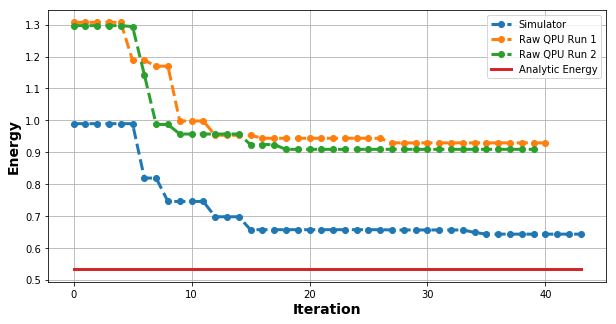

In [23]:
"""Plot the QPU energy vs iteration data obtained by running on Rigetti QCS."""
# Read in the files
qpu_energy1 = np.loadtxt("qpu-energy-iteration1.txt")
qpu_energy2 = np.loadtxt("qpu-energy-iteration2.txt")

# Do the plotting
plt.figure(figsize=(10, 5))
plt.plot(energies, "--o", linewidth=3, label="Simulator")
plt.xlabel("Iteration", fontsize=14, fontweight="bold")
plt.ylabel("Energy", fontsize=14, fontweight="bold")

plt.plot(qpu_energy1, "--o", linewidth=3, label="Raw QPU Run 1")
plt.plot(qpu_energy2, "--o", linewidth=3, label="Raw QPU Run 2")

# Put a line at the actual ground state energy (see below)
GSENERGY = 0.53232723
plt.plot(GSENERGY * np.ones_like(energies), linewidth=3, label="Analytic Energy")

plt.grid()
plt.legend();

## <p style="text-align: center;"> Error Mitigation </p>

The QPU data above has a significant vertical shift from the simulator data, but generally the same "shape." This shift is present because of decoherence, gate application errors, measurement errors, and other noise in the system. It can be accounted for by running a set of "benchmark circuits" on the QPU prior to running the actual algorithm. These benchmark circuits are simple circuits, such as NOT and MEASURE, for which one knows the actual output. The vertical shift in this benchmark circuit can then be tested for and subtracted from the final computed energies to get more accurate results. Other methods are also possible, and this is an area of active research.

Here, we employ a similar idea, but instead of running a benchmark circuit, we just subtract off the difference of the initial energies on the QPU and on the simulator. The cell below implements this and plots the result again.

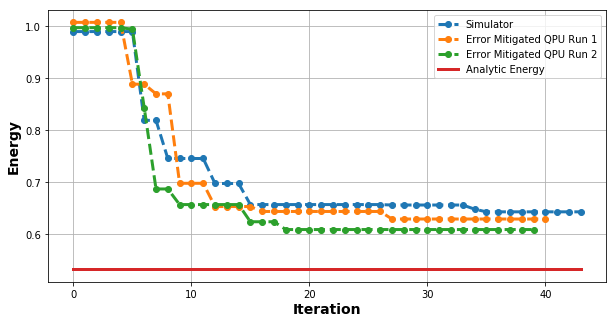

In [24]:
"""Plot the error mitigated QPU energy vs iteration data obtained by running on Rigetti QCS."""
# Constant shift amount. In practice, this would be obtained by running a "benchmark circuit."
# Here, we just set the value based on the above curves
shift = 0.3

# Read in the files
qpu_energy1 = np.loadtxt("qpu-energy-iteration1.txt")
qpu_energy2 = np.loadtxt("qpu-energy-iteration2.txt")

# Subtract off the shift
qpu_energy1 -= shift
qpu_energy2 -= shift

# Do the plotting
plt.figure(figsize=(10, 5))
plt.plot(energies, "--o", linewidth=3, label="Simulator")
plt.xlabel("Iteration", fontsize=14, fontweight="bold")
plt.ylabel("Energy", fontsize=14, fontweight="bold")

plt.plot(qpu_energy1, "--o", linewidth=3, label="Error Mitigated QPU Run 1")
plt.plot(qpu_energy2, "--o", linewidth=3, label="Error Mitigated QPU Run 2")

# Put a line at the actual ground state energy (see below)
GSENERGY = 0.53232723
plt.plot(GSENERGY * np.ones_like(energies), linewidth=3, label="Analytic Energy")

plt.grid()
plt.legend();

## <p style="text-align: center;"> Conclusions and Future Work </p>

In this project, we mapped a simple quantum field theory onto a quantum computer architecture and computed the ground state energy via the variational quantum eigensolver algorithm. We ran our algorithm on a quantum computer simulator and compared our results, both ground state energy and ground state wavefunction, to the analytical results found by classically diagonalizing the Hamiltonian. Our results were in good agreement but could be improved upon by a more sophisticated variational ansatz and, potentially, better minimization algorithms. 

In future work, we could use quantum algorithms to approximate excited state energies and compute the mass renormalization of the interacting $\lambda \phi^4$ field theory. Additionally, we could consider other quantum field theories and obtain a quantum algorithm with the same digitization techniques used in this project. Future work could be done on error mitigation to obtain more accurate energy estimates. Additionally, we could consider other algorithms for computing eigenvalues such as the well-known quantum phase estimation algorithm. While QPE is not near-term, it would be interesting to compare results obtained with QPE vs. those obtained with VQE.

## <p style="text-align: center;"> Acknowledgements </p>

I thank Dr. Shindler for very helpful discussions about the one-dimensional field theory considered in this work. I thank Rigetti for providing access to their quantum computers. The views expressed in this work are my own and not those of Rigetti. Finally, I still thank Yousif Almulla for providing skeleton code from way back for my first implementation of VQE (not for this project). The code was slow, poorly commented, and outright confounding, but it helped explain how VQE works at a low-level for me.

## <p style="text-align: center;"> References </p>

[1] Ryan LaRose, <a href="https://quantum-journal.org/papers/q-2019-03-25-130/">Overview and comparison of gate level quantum software platforms</a>, Quantum <b>3</b>: 130 (2019).

[2] Kubra Yeter-Aydeniz, Eugene F. Dumitrescu, Alex J. McCaskey, Ryan S. Bennink, Raphael C. Pooser, and George Siopsis, "Scalar Quantum Field Theories as a Benchmark for Near-Term Quantum Computers," Phys. Rev. A <b>99</b>, 032306, 2019.

[3] Ken M Nakanishi, Kosuke Mitarai, and Keisuke Fujii, "Subspace-search variational quantum eigensolver for excited states," <a href="https://arxiv.org/abs/1810.09434">https://arxiv.org/abs/1810.09434</a>, 2019.

[4] Natalie Klco and Marin J. Savage, "Digitization of Scalar Fields for NISQ-Era Quantum Computing," <a href="https://arxiv.org/abs/1808.10378">https://arxiv.org/abs/1808.10378</a>, 2018.